# Metadata

```yaml
Course:  DS 5001
Module:  03 Lab
Topic:   Inferring Language Models
Version: 1
Author:  R.C. Alvarado
Date:    22 January 2022 (modified)
```

**Purpose**: 

We now create a series of simple n-gram langage models from a set of novels and evaluate them.

We don't worry about missing words, smoothing, etc. This is just to demonstrate how we convert the counts from a token table into a language model.

## Set Up

### Configure

In [1]:
data_in = "./data_in"
data_out = './data_out'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
text_file1 = f'{data_in}/austen-persuasion.csv'
text_file2 = f'{data_in}/austen-sense.csv'

### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Import and combine texts

In [4]:
text1 = pd.read_csv(text_file1)
text2 = pd.read_csv(text_file2)

In [5]:
text1.head(10)

,chap_num,para_num,sent_num,token_num,token_str,term_str
0,1,0,0,0,Sir,sir
1,1,0,0,1,Walter,walter
2,1,0,0,2,Elliot,elliot
3,1,0,0,3,of,of
4,1,0,0,4,Kellynch,kellynch
5,1,0,0,5,Hall,hall
6,1,0,0,6,in,in
7,1,0,0,7,Somersetshire,somersetshire
8,1,0,0,8,was,was
9,1,0,0,9,a,a


In [6]:
text1['book_id'] = 1
text2['book_id'] = 2

In [7]:
text1.head()

,chap_num,para_num,sent_num,token_num,token_str,term_str,book_id
0,1,0,0,0,Sir,sir,1
1,1,0,0,1,Walter,walter,1
2,1,0,0,2,Elliot,elliot,1
3,1,0,0,3,of,of,1
4,1,0,0,4,Kellynch,kellynch,1


In [8]:
tokens = pd.concat([text1, text2]).dropna().set_index(OHCO)

In [9]:
tokens.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0               Sir       sir
                                   1            Walter    walter
                                   2            Elliot    elliot
                                   3                of        of
                                   4          Kellynch  kellynch

## Extract a vocabulary

### Nornalize tokens

We use a simple normalization scheme -- remove all non-alphanumeric characters, including underscores.

In [10]:
tokens['term_str'] = tokens['token_str'].str.lower().str.replace(r'[\W_]', '', regex=True).dropna()

In [11]:
tokens

token_str    term_str
book_id chap_num para_num sent_num token_num                        
1       1        0        0        0                 Sir         sir
                                   1              Walter      walter
                                   2              Elliot      elliot
                                   3                  of          of
                                   4            Kellynch    kellynch
...                                                  ...         ...
        24       13       0        6                  of          of
                                   7          Persuasion  persuasion
                                   8                  by          by
                                   9                Jane        jane
                                   10             Austen      austen

[84123 rows x 2 columns]

### Count tokens

We create a dataframe of unique tokens, i.e. token *types*, which we will call "terms". Our first feature will be their counts.

In [12]:
vocab = tokens['term_str'].value_counts()\
    .to_frame()\
    .reset_index()\
    .rename(columns={'term_str':'n', 'index':'term_str'})\
    .sort_values('term_str')
vocab = vocab[vocab.term_str != '']
vocab = vocab.set_index('term_str')

In [13]:
vocab.tail()

,n
term_str,
youthful,1
z,1
zeal,5
zealous,2
zealously,1


### Quick look at most frequent terms

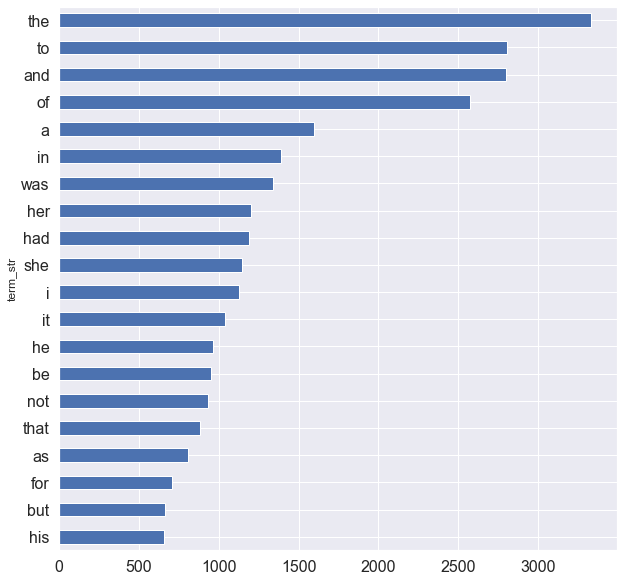

In [230]:
vocab.n.nlargest(20).sort_values().plot.barh(figsize=(10,10), fontsize=16);

## Simple Unigram Model

### Extract probability features ($p$, $i$, and $h$)

We use $i$ to stand for the inverse log probability of $x$, following our intuition that it represents information as "surprisal".

$ i(x) = log_2(\frac{1}{p(x)}) $

$i$ is the inverse of log probability, second term in the entropy formula $ H(x) = \sum_x p(x) log_2(\frac{1}{p(x)}) $

In [16]:
n_tokens = vocab.n.sum()
n_terms = vocab.n.count() # same as vocab.shape[0]
vocab['p'] = vocab['n'] / n_tokens
vocab['p2'] = vocab['n'] / n_terms # Some sources say to do this, but it makes no sense
vocab['i'] = np.log2(1/vocab['p'])
vocab['h'] = vocab['p'] * vocab['i']

In [17]:
vocab.sort_values('p', ascending=False)

,n,p,p2,i,h
term_str,,,,,
the,3330,0.039585,0.578225,4.658906,0.184422
to,2808,0.033380,0.487585,4.904885,0.163724
and,2800,0.033285,0.486196,4.909002,0.163394
of,2572,0.030574,0.446605,5.031538,0.153836
a,1595,0.018960,0.276958,5.720872,0.108470
...,...,...,...,...,...
prey,1,0.000012,0.000174,16.360213,0.000194
priced,1,0.000012,0.000174,16.360213,0.000194
equalled,1,0.000012,0.000174,16.360213,0.000194


### Compute Entropy of the model

In [27]:
H = vocab.h.sum()

In [28]:
H

9.055747528965991

### Compute Redundancy

In [29]:
Hmax = np.log2(n_terms)
R = 1 - (H/Hmax)

In [32]:
int(round(R, 2) * 100)

28

So, the redundancy of Austen's English from these two novels $R_{austen}$ is about $30\%$. Shannon estimated the redundancy of English $R_{english}$ to be $54\%$ (see Shannon 1953 in the Readings).

### Predict Senteces

In [227]:
import re

def predict_sentence(sent_str, smooth = .5):
        
    # Parse sentence into tokens and normalize string
    S = sent_str.lower().split()
    S = [re.sub(r'[\W_]+', '', s) for s in S]
    N = len(S)
    
    # Handle out of vocabulary words
    OOV = [(w, smooth) for w in list(set(S) - set(vocab.index))]
    if len(OOV) > 0:
        V = vocab[['n']].append(pd.DataFrame(OOV, columns=['term_str','n']).set_index('term_str')).copy()
        V['p'] = V.n / V.n.sum()
    else:
        V = vocab[['n','p']].copy()
        
    V['i'] = np.log2(1/V.p)
    
    # Create dataframe of tokens from sentence
    tokens = pd.DataFrame(S, columns=['term_str']).set_index('term_str')
    
    # Link the tokens with model vocabulary
    tokens = tokens.merge(V, on='term_str')
    
    # Compute Perplexity
    pp = 2**(tokens.i.sum()/N)
            
    return (sent_str, pp)


In [228]:
test_sentences = """
I love you
I love cars
I want to
Anne said to
said to her
said to him
she read the
""".split('\n')[1:-1]
pdata = []
for S in test_sentences:
    pdata.append(predict_sentence(S))

In [229]:
pd.DataFrame(pdata, columns=['sent_str', 'pp']).sort_values('pp').style.background_gradient()

,sent_str,pp
4,said to her,100.590783
3,Anne said to,135.097782
5,said to him,137.930843
2,I want to,182.560318
6,she read the,228.941233
0,I love you,271.804309
1,I love cars,2932.617790


## N-Gram models

This function generates models up to the length specified.

In [242]:
def get_ngrams(n=2):
    """Generate n-gram models for each value of n"""
    
    global tokens, OHCO
    
    # Create list to store copies of tokens table
    X = []
    
    # Convert the index to cols in order to change the value of token_num
    X.append(tokens['term_str'].reset_index())
        
    # Create copies of token table for each level of ngram, offset by 1, and 
    # merge with previous 
    for i in range(1, n):
        
        # Append a new copy of the token list
        X.append(X[0].copy()) 
        
        # Offset the token num by 1 each time
        X[i]['token_num'] = X[i]['token_num'] + i 
        
        # Merge the new dataframe with the previous, using the OHCO as key, 
        # to preserve structure, including sentence boundaries
        X[i] = X[i].merge(X[i-1], on=OHCO, how='left', 
                          sort=True, 
                          suffixes=[f"{i}", f"{i+1}"]).fillna('<s>')
        
        print(i)
        print(X[i].head())
        print('-' * 40)
    
    # Compress tables to unique ngrams with counts; 
    for i in range(0, n):
        X[i] = X[i].drop(OHCO, axis=1)
        cols = X[i].columns.tolist()
        X[i] = X[i].value_counts().to_frame('n')
        X[i].index.names = [f'w{j}' for j in range(i+1)]
        X[i] = X[i].sort_index()
            
    # Return just the ngram tables
    return X

### Generate three models

Unigram, bigram, and trigram

In [243]:
m1, m2, m3 = get_ngrams(n=3)

1
   book_id  chap_num  para_num  sent_num  token_num term_str1 term_str2
0        1         1         0         0          1       sir    walter
1        1         1         0         0          2    walter    elliot
2        1         1         0         0          3    elliot        of
3        1         1         0         0          4        of  kellynch
4        1         1         0         0          5  kellynch      hall
----------------------------------------
2
   book_id  chap_num  para_num  sent_num  token_num  term_str term_str1  \
0        1         1         0         0          2       sir    walter   
1        1         1         0         0          3    walter    elliot   
2        1         1         0         0          4    elliot        of   
3        1         1         0         0          5        of  kellynch   
4        1         1         0         0          6  kellynch      hall   

  term_str2  
0    elliot  
1        of  
2  kellynch  
3      hall  
4 

In [233]:
m3

n
w0        w1          w2          
1         1760        married    1
          1785        <s>        1
15        1784        elizabeth  1
16        1810        charles    1
1760      married     july       1
...                             ..
zeal      of          the        1
          to          dwell      1
zealous   officer     too        1
          on          the        1
zealously discharging all        1

[68780 rows x 1 columns]

In [161]:
m2.sort_values('n', ascending=False).head(10)

,,n
w0,w1,
of,the,426
to,be,378
in,the,322
had,been,255
she,had,227
it,was,220
captain,wentworth,196
he,had,191
to,the,175


In [162]:
m3.loc[('captain','wentworth')].sort_values('n', ascending=False)

,n
w2,
<s>,26
s,26
was,15
in,8
had,7
...,...
looked,1
long,1
left,1


In [163]:
m3.loc[('anne','elliot')].sort_values('n', ascending=False)

,n
w2,
<s>,6
and,3
as,2
with,2
again,1
deprived,1
had,1
have,1
should,1


### Compute joint probabilities

In [164]:
m1['p'] = m1['n'] / m1['n'].sum()
m2['p'] = m2['n'] / m2['n'].sum()
m3['p'] = m3['n'] / m3['n'].sum()

In [165]:
m1.sort_values('p', ascending=False).head()

,n,p
w0,,
the,3330,0.039585
to,2808,0.033380
and,2800,0.033285
of,2572,0.030574
a,1595,0.018960


In [166]:
m2.sort_values('p', ascending=False).head()

,,n,p
w0,w1,,
of,the,426,0.005064
to,be,378,0.004493
in,the,322,0.003828
had,been,255,0.003031
she,had,227,0.002698


In [167]:
m3.sort_values('p', ascending=False).head(15)

,,,n,p
w0,w1,w2,,
it,<s>,<s>,119,0.001415
him,<s>,<s>,117,0.001391
her,<s>,<s>,106,0.001260
them,<s>,<s>,73,0.000868
me,<s>,<s>,62,0.000737
you,<s>,<s>,60,0.000713
elliot,<s>,<s>,57,0.000678
she,could,not,54,0.000642
oh,<s>,<s>,46,0.000547


### Compute conditional probabilities

$p(w_1|w_0) = p(w_0, w_1) / p(w_0)$

$p(w_2|w_0,w_1) = p(w_0, w_1, w_2) / p(w_0, w_1)$

In [176]:
# m2['cp'] = (m2.n / m1.n).sort_values().to_frame('p').sort_index()

In [182]:
m2['m1n'] = m1.n
m2['cp'] = m2.n / m2.m1n

In [175]:
m2

n         p  m1   cp  m1n
w0        w1                                    
1         1760         1  0.000012   2  0.5    2
          1785         1  0.000012   2  0.5    2
15        1784         1  0.000012   1  1.0    1
16        1810         1  0.000012   1  1.0    1
1760      married      1  0.000012   1  1.0    1
...                   ..       ...  ..  ...  ...
zeal      of           1  0.000012   5  0.2    5
          to           1  0.000012   5  0.2    5
zealous   officer      1  0.000012   2  0.5    2
          on           1  0.000012   2  0.5    2
zealously discharging  1  0.000012   1  1.0    1

[39897 rows x 5 columns]

In [188]:
# m3['cp'] = (m3.n / m2.n).sort_values().to_frame('p').sort_index()

In [189]:
m3['m2n'] = m2.n
m3['cp'] = m3.n / m3.m2n

In [190]:
m3.sort_values('cp', ascending=False)

n         p  m2n        cp
w0     w1   w2                                     
1      1760 married      1  0.000012    1  1.000000
myself at   deal         1  0.000012    1  1.000000
       for  ever         1  0.000012    1  1.000000
       i    certainly    1  0.000012    1  1.000000
       in   the          1  0.000012    1  1.000000
...                     ..       ...  ...       ...
of     the  manner       1  0.000012  426  0.002347
            lodge        1  0.000012  426  0.002347
            least        1  0.000012  426  0.002347
            laws         1  0.000012  426  0.002347
            arrangement  1  0.000012  426  0.002347

[68780 rows x 4 columns]

In [191]:
m2.cp.unstack(fill_value=0)

w1,1,15,16,1760,1784,1785,1787,1789,1791,1800,...,your,yours,yourself,yourselves,youth,youthful,z,zeal,zealous,zealously
w0,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youthful,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zeal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
m3.cp.unstack(fill_value=0)

w2                       1   15   16  1760  1784  1785  1787  1789  1791  \
w0        w1                                                               
1         1760         0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          1785         0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
15        1784         0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
16        1810         0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1760      married      0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                    ...  ...  ...   ...   ...   ...   ...   ...   ...   
zeal      of           0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          to           0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zealous   officer      0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
          on           0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
zealously discharging  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

w2                     1800  ...  your  yours  yourself  yourselves  youth  \
w0        w1                 ...                                             
1         1760          0.0  ...   0.0    0.0       0.0         0.0    0.0   
          1785          0.0  ...   0.0    0.0       0.0         0.0    0.0   
15        1784          0.0  ...   0.0    0.0       0.0         0.0    0.0   
16        1810          0.0  ...   0.0    0.0       0.0         0.0    0.0   
1760      married       0.0  ...   0.0    0.0       0.0         0.0    0.0   
...                     ...  ...   ...    ...       ...         ...    ...   
zeal      of            0.0  ...   0.0    0.0       0.0         0.0    0.0   
          to            0.0  ...   0.0    0.0       0.0         0.0    0.0   
zealous   officer       0.0  ...   0.0    0.0       0.0         0.0    0.0   
          on            0.0  ...   0.0    0.0       0.0         0.0    0.0   
zealously discharging   0.0  ...   0.0    0.0       0.0         0.0    0.0   

w2                     youthful    z  zeal  zealous  zealously  
w0        w1                                                    
1         1760              0.0  0.0   0.0      0.0        0.0  
          1785              0.0  0.0   0.0      0.0        0.0  
15        1784              0.0  0.0   0.0      0.0        0.0  
16        1810              0.0  0.0   0.0      0.0        0.0  
1760      married           0.0  0.0   0.0      0.0        0.0  
...                         ...  ...   ...      ...        ...  
zeal      of                0.0  0.0   0.0      0.0        0.0  
          to                0.0  0.0   0.0      0.0        0.0  
zealous   officer           0.0  0.0   0.0      0.0        0.0  
          on                0.0  0.0   0.0      0.0        0.0  
zealously discharging       0.0  0.0   0.0      0.0        0.0  

[39897 rows x 5637 columns]

## Predict Sentences

In [61]:
def predict_sentence2(sent_str, M):
    
    # Model order
    n = len(M.index.names)
    
    # Parse sentence into tokens and normalize string
    S = sent_str.lower().split()
    S = [re.sub(r'[\W_]+', '', s) for s in S]
    S = S + ['<s>' for i in range(n-1)]
    N = len(S)
    
    # Generate ngram keys 
    ngrams = []
    offset = n - 1
    for i in range(offset, len(S)):
        ngram = []
        w = S[i]
        for j in range(n):
            ngram.append(S[i-j])
        ngram.reverse()
        ngrams.append(ngram)
        
    # Get smoothing -- HACK
    smooth = M.p.min()
            
    # Compute the probability of the sentence
    log_prob = 0
    for ngram in ngrams:
        try:
            p_ngram = M.loc[tuple(ngram)].p
        except KeyError:
            p_ngram = smooth
        log_prob += np.log(p_ngram)
    p = np.exp(log_prob)
    pp = round(p**(-1/N)) 
    
    return([n, sent_str, p, pp])

In [62]:
test_sentences = """
I love you
I love cars
I want to
Anne said to
said to her
said to him
she read the
""".split('\n')[1:-1]
pdata = []
for S in test_sentences:
    pdata.append(predict_sentence2(S, m1))
    pdata.append(predict_sentence2(S, m2))
    pdata.append(predict_sentence2(S, m3))
R1 = pd.DataFrame(pdata, columns=['model','sent_str', 'p', 'pp']).set_index(['sent_str','model'])

In [63]:
cols = [1,2,3]
pd.concat([R1.p.unstack().rename(columns={col:f"p{col}" for col in cols}), 
           R1.pp.unstack().rename(columns={col:f"pp{col}" for col in cols} )], axis=1).style.background_gradient()

model,p1,p2,p3,pp1,pp2,pp3
sent_str,,,,,,
Anne said to,0.000000,0.000000,0.000000,135,1940,532
I love cars,0.000000,0.000000,0.000000,2328,4940,901
I love you,0.000000,0.000000,0.000000,272,1775,397
I want to,0.000000,0.000000,0.000000,183,1208,532
said to her,0.000001,0.000000,0.000000,101,375,201
said to him,0.000000,0.000000,0.000000,138,463,208
she read the,0.000000,0.000000,0.000000,229,4940,901


## Explore Pairs

In [64]:
def explore_pairs(list1, list2):
    global m2
    test_pairs = []
    for pair in zip(list1, list2):
        try:
            m2.loc[pair]
            test_pairs.append(pair)
        except:
            pass
    return m2.loc[test_pairs].cp.unstack(fill_value=0).style.background_gradient()

In [65]:
explore_pairs(['he','she','it','anne','wentworth'], ['is','had','was','did','felt','thought','looked','said','saw'])

w1,is,had,was,did
w0,,,,
he,0.048907,0.000000,0.000000,0.000000
she,0.000000,0.198080,0.000000,0.000000
it,0.000000,0.000000,0.211946,0.000000
anne,0.000000,0.000000,0.000000,0.016097


In [66]:
explore_pairs(['he', 'she', 'it'], ['said','felt'])

w1,said,felt
w0,,
he,0.012487,0.000000
she,0.000000,0.022688


## Generate Text

We use stupid back-off to account for missing ngrams.

In [67]:
def generate_text(start_word='she', n=250):
    words = [start_word]
    for i in range(n):
        if len(words) == 1:
            w = m2.loc[start_word].p
            next_word = m2.loc[start_word].sample(weights=w).index.values[0]
        elif len(words) > 1:
            bg = tuple(words[-2:])
            try:
                w = m3.loc[bg].p
                next_word = m3.loc[bg].sample(weights=w).index.values[0]
            except KeyError:
                ug = bg[1]
                if ug == '<s>':
                    next_word = m1.sample(weights=m1.p).index[0]
                else:
                    w = m2.loc[ug].p
                    next_word = m2.loc[ug].sample(weights=w).index.values[0]
        words.append(next_word)
    text = ' '.join(words)
    text = text.replace(' <s> <s>', '.') + '.'
    text = text.upper() # To give that telegraph message look :-)
    print(text)

In [68]:
generate_text('the')

THE PERFECTION OF HER OWN CONSCIENCE PROMPTED SHE BELIEVED A VERY DIFFERENT DESCRIPTION. FOR HENRIETTA BUT CHARLES THOUGH IN AN INTERESTING SOUND TO ME. THE INTEREST HE HOPED WOULD DO NOTHING TOWARDS TRANQUILLITY. IDEA AS NURSE TELLS ME THAT YOU HAD BEEN ELOQUENT ON THE MORROW. WHOLE SOLITARY EVENING IN CAMDEN PLACE AMIDST THE DASH OF OTHER MEN ABOUT THOSE THINGS ARE TOO COMMON. TO MORROW EVENING. MIGHT HAVE BEEN TRYING TO FIND THEIR OWN GAME TO BE OF NO USE TO YOU THAT NOTHING WAS TO BE WITH THE ADVANTAGE OF MATURITY OF MIND. CRIED MARY TO ANNE. LARGE FISHING NET AT ONE OF THEIR ATTACHMENTS. WAS HIS CONSTANT OBJECT OF COLONEL WALLIS. ALL AND HER FINE LITTLE BOYS ANNE WAS AMONG THOSE WHO ARE NOT ON THIS ARGUMENT OF RATIONAL DEPENDENCE. AS TO MAKE ABOUT HER IN BATH WAS GROWING CALMER. A SLIGHT NOISE CALLED THEIR ATTENTION WAS CALLED ON HER. AMONG THE NOBILITY OF ENGLAND AND IRELAND. USEFUL. YOU. IS JUST RETURNED TO ENGLAND OR PAID OFF OR SOMETHING AND IS PERFECTLY SURE THAT HE COULD MEE

In [69]:
generate_text('she')

SHE HOWEVER WAS DIVERSIFIED IN A COMMON THING. SHOULD BE COME TO NOTHING AT ALL. ALL AWARE OF THE LADY OF THE DAY SHE FELT THAT HE WAS CONTINUALLY REQUESTED OR AT LEAST IF YOU WOULD HAVE EXPECTED HER THOUGH HE HAD PROBABLY NEVER HEARD AND MR AND MRS CROFT SHOULD BE COME TO MORROW IF YOU ARE TIRED. IT IS NOT QUITE UNCONNECTED IN THIS WAY THAT BUSY AS SHE MIGHT CONVEY HER AS HE BECAME FULLY SATISFIED OF HIS LIFE. SHE HOPED ON TURNING HER HEAD IS NOT UNLIKELY TO MARRY CAPTAIN BENWICK WHO SEEMED PARTICULARLY ATTACHED AND HAPPY ANNE COULD LISTEN NO LONGER NOBODY. MARRY AT ONCE SUIT HER AND THEN ELIZABETH WAS REPLYING IN A LETTER FROM HIM NOT SO MUCH TO RECOVER FROM THE CONCERT ROOM STILL GOVERNED. QUIT THAT ROOM IT WOULD BE HARD INDEED WITH A YOUNG DAB CHICK IN THE NORTH OF THE ROOM. A LARGE PARTY NOW FILLING THE DRAWING ROOMS WERE SHUT UP THE TOWN. AGO AS SEPTEMBER IN SHORT WITH A RECOMMENDATION FROM HIS HEART FAILED HIM AND HER CONSCIENCE ADMITTED THAT HIS FACE THE COLOUR INTO HER AS ABLE

## Save

In [70]:
vocab.to_csv(f"{data_out}/austen-VOCAB.csv", index=True)
tokens.to_csv(f"{data_out}/austen-TOKENS.csv", index=True)
m1.to_csv(f"{data_out}/austen-M1.csv", index=True)
m2.to_csv(f"{data_out}/austen-M2.csv", index=True)
m3.to_csv(f"{data_out}/austen-M3.csv", index=True)